In [2]:
# d'apres https://arun-thomas.xyz/2019-06-18-BearingAnalytics/

# library
import os
import pandas as pd
import numpy as np
from sklearn import preprocessing
import seaborn as sns
# sns.set(color_codes=True)

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

### Load data
Gear degradation occur gradually over time, so we use one datapoint every 10 minutes in the following analysis.

In [6]:
merged_data = pd.read_csv('../data/merged_dataset_BearingTest_2.csv')

merged_data.columns = ['dt','Bearing 1','Bearing 2','Bearing 3','Bearing 4']
merged_data=merged_data.set_index('dt')

In [7]:
merged_data.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
dt,,,,
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


In [10]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 984 entries, 2004-02-12 10:32:39 to 2004-02-19 06:22:39
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Bearing 1  984 non-null    float64
 1   Bearing 2  984 non-null    float64
 2   Bearing 3  984 non-null    float64
 3   Bearing 4  984 non-null    float64
dtypes: float64(4)
memory usage: 38.4+ KB


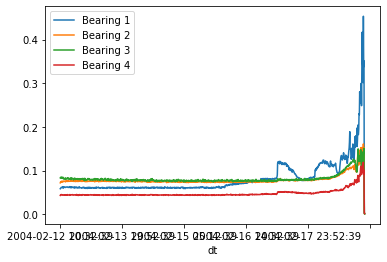

In [14]:
merged_data.plot()


In [15]:
# Split data
dataset_train = merged_data['2004-02-12 11:02:39':'2004-02-13 23:52:39']
dataset_test = merged_data['2004-02-13 23:52:39':]

dataset_train.shape, dataset_test.shape

((222, 4), (760, 4))

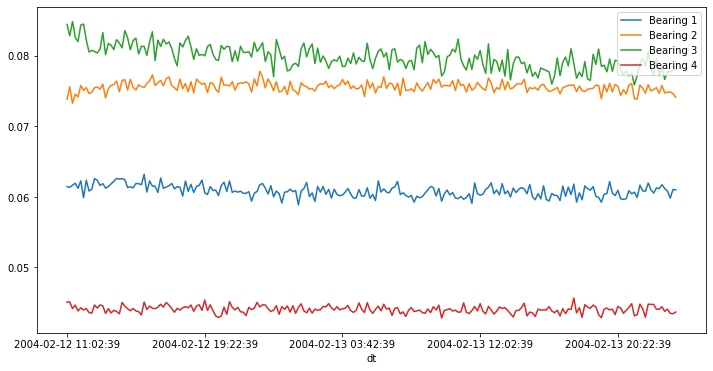

In [16]:
dataset_train.plot(figsize = (12,6))
plt.show()

### Normalize data

In [17]:
# The “MinMaxScaler” simply re-scales the data to be in the range [0,1]
scaler = preprocessing.MinMaxScaler()

X_train = pd.DataFrame(scaler.fit_transform(dataset_train), 
                              columns=dataset_train.columns, 
                              index=dataset_train.index)

In [18]:
# Random shuffle training data
X_train.sample(frac=1)

X_test = pd.DataFrame(scaler.transform(dataset_test), 
                             columns=dataset_test.columns, 
                             index=dataset_test.index)

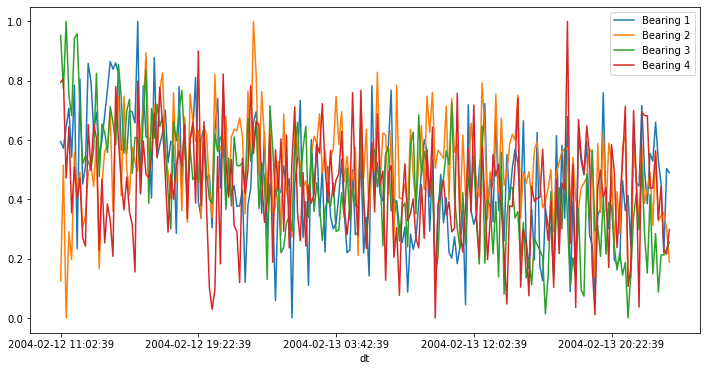

In [19]:
X_train.plot(figsize = (12,6))
plt.show()

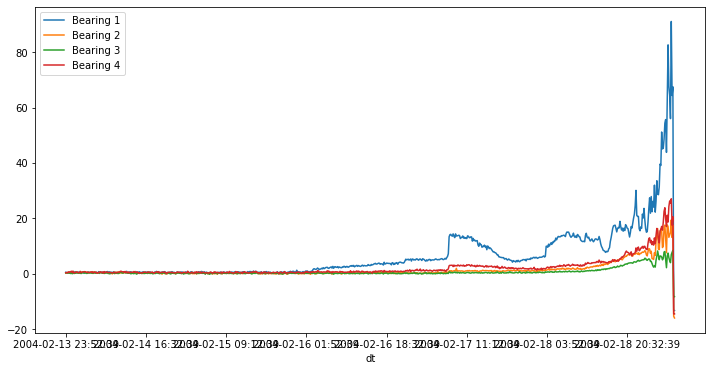

In [20]:
X_test.plot(figsize = (12,6))

In [21]:
X_train.head()

,Bearing 1,Bearing 2,Bearing 3,Bearing 4
dt,,,,
2004-02-12 11:02:39,0.594640,0.125020,0.953188,0.794650
2004-02-12 11:12:39,0.572777,0.515185,0.773329,0.807756
2004-02-12 11:22:39,0.642988,0.000000,1.000000,0.472299
2004-02-12 11:32:39,0.707427,0.290580,0.749966,0.644737
2004-02-12 11:42:39,0.542705,0.197430,0.682892,0.354536


### Model

In [22]:
# PCA sur le train qu'on applique sur le test
# chaque point est un instant t avec 4 capteurs
from sklearn.decomposition import PCA
pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(X_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = X_train.index

X_test_PCA = pca.transform(X_test)
X_test_PCA = pd.DataFrame(X_test_PCA)
X_test_PCA.index = X_test.index

In [23]:
def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [24]:
# Mahalanobis distance
def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

In [25]:
# Detecting outliers
def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

In [26]:
# Calculate threshold value for classifying datapoint as anomaly:
def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

In [27]:
# Check if matrix is positive definite:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

In [28]:
# Define train/test set from the two main principal components:
data_train = np.array(X_train_PCA.values)
data_test = np.array(X_test_PCA.values)

In [29]:
# Calculate the covariance matrix and its inverse, based on data in the training set:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)

In [30]:
cov_matrix

array([[6.83095186e-02, 3.06859823e-18],
       [3.06859823e-18, 2.73966938e-02]])

In [31]:
inv_cov_matrix

array([[ 1.46392482e+01, -1.63968585e-15],
       [-1.63968585e-15,  3.65007547e+01]])

In [32]:
# calculate the mean value for the input variables in the training set
mean_distr = data_train.mean(axis=0)
mean_distr

array([-1.60032148e-17,  2.40048222e-17])

In [33]:
# calculate the Mahalanobis distance for the training data defining “normal conditions”
dist_test = MahalanobisDist(inv_cov_matrix, mean_distr, data_test, verbose=False)
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

# find the threshold value to flag datapoints as an anomaly.
threshold = MD_threshold(dist_train, extreme = True)

In [34]:
threshold

3.8120454918056756

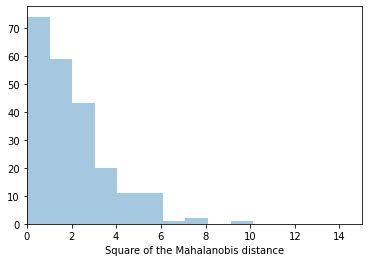

In [35]:
# visualizing the square of the Mahalanobis distance
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])
plt.xlabel('Square of the Mahalanobis distance')
plt.show()

Text(0.5, 0, 'Mahalanobis dist')

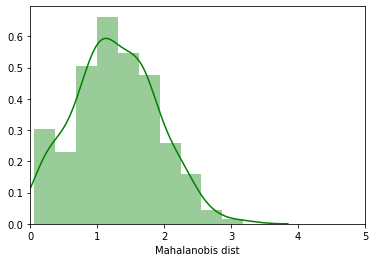

In [36]:
# visualize the Mahalanobis distance itself:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')


The calculated threshold value of 3.8 for flagging an anomaly seems reasonable (defined as 3 standard deviations from the center of the distribution)

### Anomaly detection

In [30]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index

In [31]:
anomaly_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 222 entries, 2004-02-12 11:02:39 to 2004-02-13 23:52:39
Data columns (total 3 columns):
Mob dist    222 non-null float64
Thresh      222 non-null float64
Anomaly     222 non-null bool
dtypes: bool(1), float64(2)
memory usage: 5.4 KB


In [32]:
anomaly_train.Anomaly.value_counts()

False    222
Name: Anomaly, dtype: int64

In [33]:
anomaly_train.head()

,Mob dist,Thresh,Anomaly
2004-02-12 11:02:39,1.667002,3.812045,False
2004-02-12 11:12:39,1.699415,3.812045,False
2004-02-12 11:22:39,2.671968,3.812045,False
2004-02-12 11:32:39,1.424617,3.812045,False
2004-02-12 11:42:39,1.624601,3.812045,False


Based on the calculated statistics, any distance above the threshold value will be flagged as an anomaly.

In [34]:
anomaly = pd.DataFrame()
anomaly['Mob dist']= dist_test
anomaly['Thresh'] = threshold

# If Mob dist above threshold: Flag as anomaly
anomaly['Anomaly'] = anomaly['Mob dist'] > anomaly['Thresh']
anomaly.index = X_test_PCA.index
anomaly.head()

,Mob dist,Thresh,Anomaly
2004-02-13 23:52:39,1.032676,3.812045,False
2004-02-14 00:02:39,1.148163,3.812045,False
2004-02-14 00:12:39,1.509998,3.812045,False
2004-02-14 00:22:39,1.849725,3.812045,False
2004-02-14 00:32:39,0.701075,3.812045,False


In [35]:
anomaly.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 760 entries, 2004-02-13 23:52:39 to 2004-02-19 06:22:39
Data columns (total 3 columns):
Mob dist    760 non-null float64
Thresh      760 non-null float64
Anomaly     760 non-null bool
dtypes: bool(1), float64(2)
memory usage: 18.6 KB


In [36]:
anomaly.Anomaly.value_counts()

True     409
False    351
Name: Anomaly, dtype: int64

In [37]:
anomaly_alldata = pd.concat([anomaly_train, anomaly])
#anomaly_alldata.to_csv('Anomaly_distance.csv')

In [38]:
anomaly_alldata.head(10)

,Mob dist,Thresh,Anomaly
2004-02-12 11:02:39,1.667002,3.812045,False
2004-02-12 11:12:39,1.699415,3.812045,False
2004-02-12 11:22:39,2.671968,3.812045,False
2004-02-12 11:32:39,1.424617,3.812045,False
2004-02-12 11:42:39,1.624601,3.812045,False
2004-02-12 11:52:39,2.644238,3.812045,False
2004-02-12 12:02:39,1.987715,3.812045,False
2004-02-12 12:12:39,1.786536,3.812045,False
2004-02-12 12:22:39,1.319040,3.812045,False
2004-02-12 12:32:39,1.502585,3.812045,False


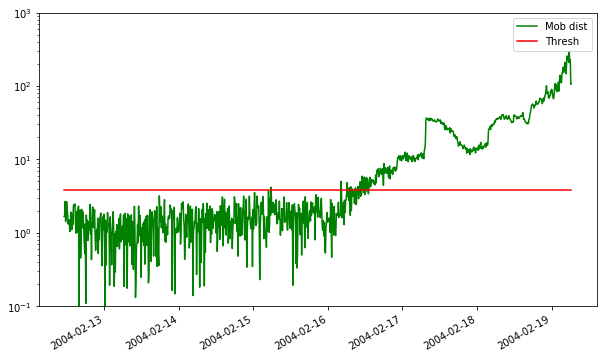

In [39]:
anomaly_alldata.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])
plt.show()

This model is able to detect the anomaly approximately 3 days ahead of the actual bearing failure.